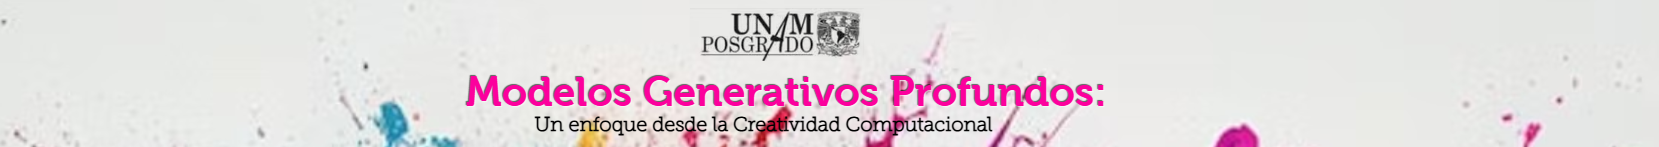

# Interpolación en el espacio latente  
### como una estrategias de control generativo en AEs y VAEs usando Fashion MNIST

En este cuaderno exploraremos la interpolación en el espacio latente como una estrategia de control generativo en autoencoders deterministas y variacionales (VAEs), utilizando el dataset Fashion-MNIST como caso de estudio.

In [1]:
import os
from tensorflow import keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np


## 1. Cargar ambos modelos ya entrenados

In [2]:
# Cargaremos los modelos desde Google Drive
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/CursoIAGenerativa/')

Mounted at /content/drive


1.1 Cargar los modelos ya entrenados del autocodificador determinista

In [4]:
drive_path = "/content/drive/My Drive/Colab Notebooks/CursoIAGenerativa/notebooks/Clase11_autoencoders_II"

# Modelos del autocodificador determinista
encoder_determinista = keras.models.load_model(os.path.join(drive_path, "encoder_det_fashion.keras"))
decoder_determinista = keras.models.load_model(os.path.join(drive_path, "decoder_det_fashion.keras"))

1.2 Cargar los modelos ya entrenados del autocodificador variacional

In [5]:
# ==============================================================
# NOTA IMPORTANTE:
# En el VAE necesitamos una capa personalizada llamada "Sampling",
# que implementa el truco de reparametrización:
#        z = mean + exp(log_var / 2) * epsilon
#
# Keras no incluye esta capa de forma nativa. Cuando guardamos y
# cargamos un modelo que la usa, Keras solo guarda una referencia
# con el nombre "Sampling", pero no el código de la clase.
#
# Por eso debemos volver a definirla aquí antes de cargar el encoder
# entrenado, para que Keras pueda reconstruir correctamente el modelo.
# ==============================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [6]:
# Modelos del autocodificador variacional
encoder_variacional = keras.models.load_model(
    os.path.join(drive_path, "encoder_vae_fashion.keras"),
    custom_objects={"Sampling": Sampling}
)
decoder_variacional = keras.models.load_model(os.path.join(drive_path, "decoder_vae_fashion.keras"))

## 3. Dercargar el dataset Fashion MNIST y pre-procesar las imágenes

In [7]:
# Tomar un batch de imágenes de prueba
# Si usas Fashion-MNIST cargado con keras.datasets
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


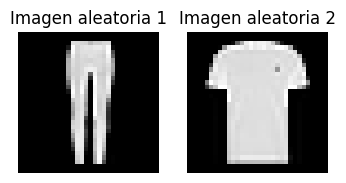

In [8]:
#import numpy as np
#import matplotlib.pyplot as plt

# Seleccionar dos ejemplos al azar de x_test
indices = np.random.choice(len(x_test), 2, replace=False)
img1, img2 = x_test[indices]

# Mostrar imágenes
plt.figure(figsize=(4, 2))

plt.subplot(1, 2, 1)
plt.imshow(img1.squeeze(), cmap="gray")  # quitar canal y forzar gris
plt.title("Imagen aleatoria 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2.squeeze(), cmap="gray")
plt.title("Imagen aleatoria 2")
plt.axis("off")

plt.show()


# 4. Interpolación en el espacio latente

###4.1 Seleccionar dos imágenes aleatorias

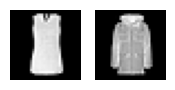

In [9]:
# Seleccionar dos ejemplos al azar de x_test
indices = np.random.choice(len(x_test), 2, replace=False)
img1, img2 = x_test[indices]

# Mostrar imágenes
plt.figure(figsize=(2, 1))

plt.subplot(1, 2, 1)
plt.imshow(img1.squeeze(), cmap="gray")  # quitar canal y forzar gris
#plt.title("Imagen aleatoria 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2.squeeze(), cmap="gray")
#plt.title("Imagen aleatoria 2")
plt.axis("off")

plt.show()

### 4.1 Interpolación con el AE determinista

In [10]:
import gradio as gr
import cv2

# Codificar dos imágenes de prueba (img1, img2 ya deben estar cargadas de Fashion-MNIST)
z1 = encoder_determinista.predict(np.expand_dims(img1, 0))
z2 = encoder_determinista.predict(np.expand_dims(img2, 0))

# Decodificar extremos
recon1 = decoder_determinista.predict(z1)[0]
recon2 = decoder_determinista.predict(z2)[0]

# Convertir a uint8, eliminar canal y reescalar de 32x32 → 60x60
recon1 = cv2.resize((recon1 * 255).astype(np.uint8).squeeze(), (60, 60), interpolation=cv2.INTER_NEAREST)
recon2 = cv2.resize((recon2 * 255).astype(np.uint8).squeeze(), (60, 60), interpolation=cv2.INTER_NEAREST)

def interpolate(alpha):
    """Interpolación lineal entre z1 y z2 en AE determinista"""
    z_interp = (1 - alpha) * z1 + alpha * z2
    recon_mid = decoder_determinista.predict(z_interp)[0]
    recon_mid = (recon_mid * 255).astype(np.uint8).squeeze()
    recon_mid = cv2.resize(recon_mid, (60, 60), interpolation=cv2.INTER_NEAREST)

    # Graficar espacio latente (solo si es 2D)
    fig, ax = plt.subplots(figsize=(4, 4))
    z1_2d, z2_2d, z_interp_2d = z1[0], z2[0], z_interp[0]
    ax.scatter(*z1_2d, color="red", label="z1")
    ax.scatter(*z2_2d, color="blue", label="z2")
    ax.scatter(*z_interp_2d, color="green", label="z_interp")
    ax.plot([z1_2d[0], z2_2d[0]], [z1_2d[1], z2_2d[1]], "k--")
    ax.legend()
    ax.set_title("Espacio latente")
    ax.grid(True)

    # Convertir figura matplotlib a numpy (para Gradio)
    fig.canvas.draw()
    latent_img = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)

    return recon1, recon_mid, recon2, latent_img

with gr.Blocks() as demo:
    gr.Markdown("### Interpolación latente entre dos prendas de Fashion-MNIST usando un Autoencoder Determinista")
    slider = gr.Slider(0, 1, value=0.5, step=0.05, label="Interpolación (α)")

    with gr.Row():
        out1 = gr.Image(type="numpy", label="Imagen 1", width=128, height=128)
        out2 = gr.Image(type="numpy", label="Interpolación", width=128, height=128)
        out3 = gr.Image(type="numpy", label="Imagen 2", width=128, height=128)
        out4 = gr.Image(type="numpy", label="Espacio latente", width=256, height=256)

    # Mostrar interpolación inicial en α=0.5
    demo.load(
        fn=interpolate,
        inputs=[slider],
        outputs=[out1, out2, out3, out4],
        queue=False
    )

    # Actualizar cuando se mueve el slider
    slider.change(fn=interpolate, inputs=slider, outputs=[out1, out2, out3, out4])

demo.launch()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://274a83a1a59309db89.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### 4.2 Interpolación con el VAE

In [11]:
# Codificar dos imágenes de prueba (img1, img2 ya deben estar cargadas de Fashion-MNIST)
z_mean1, z_log_var1, z1 = encoder_variacional.predict(np.expand_dims(img1, 0))
z_mean2, z_log_var2, z2 = encoder_variacional.predict(np.expand_dims(img2, 0))

# Usamos z_mean como punto representativo en el espacio latente
z1 = z_mean1
z2 = z_mean2

# Decodificar extremos
recon1 = decoder_variacional.predict(z1)[0]
recon2 = decoder_variacional.predict(z2)[0]

# Convertir a uint8, eliminar canal y reescalar de 32x32 → 60x60
recon1 = cv2.resize((recon1 * 255).astype(np.uint8).squeeze(), (60, 60), interpolation=cv2.INTER_NEAREST)
recon2 = cv2.resize((recon2 * 255).astype(np.uint8).squeeze(), (60, 60), interpolation=cv2.INTER_NEAREST)

def interpolate(alpha):
    """Interpolación lineal entre z1 y z2 en VAE"""
    z_interp = (1 - alpha) * z1 + alpha * z2
    recon_mid = decoder_variacional.predict(z_interp)[0]
    recon_mid = (recon_mid * 255).astype(np.uint8).squeeze()
    recon_mid = cv2.resize(recon_mid, (60, 60), interpolation=cv2.INTER_NEAREST)

    # Graficar espacio latente (solo si es 2D)
    fig, ax = plt.subplots(figsize=(4, 4))
    z1_2d, z2_2d, z_interp_2d = z1[0], z2[0], z_interp[0]
    ax.scatter(*z1_2d, color="red", label="z1")
    ax.scatter(*z2_2d, color="blue", label="z2")
    ax.scatter(*z_interp_2d, color="green", label="z_interp")
    ax.plot([z1_2d[0], z2_2d[0]], [z1_2d[1], z2_2d[1]], "k--")
    ax.legend()
    ax.set_title("Espacio latente (VAE)")
    ax.grid(True)

    # Convertir figura matplotlib a numpy (para Gradio)
    fig.canvas.draw()
    latent_img = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)

    return recon1, recon_mid, recon2, latent_img

with gr.Blocks() as demo:
    gr.Markdown("### Interpolación latente entre dos prendas de Fashion-MNIST usando un VAE")
    slider = gr.Slider(0, 1, value=0.5, step=0.05, label="Interpolación (α)")

    with gr.Row():
        out1 = gr.Image(type="numpy", label="Imagen 1", width=128, height=128)
        out2 = gr.Image(type="numpy", label="Interpolación", width=128, height=128)
        out3 = gr.Image(type="numpy", label="Imagen 2", width=128, height=128)
        out4 = gr.Image(type="numpy", label="Espacio latente", width=256, height=256)

    # Mostrar interpolación inicial en α=0.5
    demo.load(
        fn=interpolate,
        inputs=[slider],
        outputs=[out1, out2, out3, out4],
        queue=False
    )

    # Actualizar cuando se mueve el slider
    slider.change(fn=interpolate, inputs=slider, outputs=[out1, out2, out3, out4])

demo.launch()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://07ebddba2c354802fc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
